# DM1590 Final Project: News title analyzer

## Authors: Markus Brewitz, Saga Jonasson, Vilhelm Norström, Martin Ryberg Laude

---

### Background and motivation

News articles come in a variety of subjects and categories describing their field and relevance. Some of these have self-reported tags, but too many do not, or provide inaccurate tags. Tagging articles has the potential to help information-seekers to judge the relevance of articles and filter them by interest, especially in this day and age where information is so abundant it can be exhausting. In this project we set out to use machine learning to tag articles based on their titles, to aid the effort of searching for relevant information.

### Dataset

https://archive.ics.uci.edu/ml/datasets/News+Aggregator

This dataset contains a lot of information taken from different news articles, but for our intents and purposes, we will only be looking at two things: News titles, and their corresponding theme, or category:
* **b** for *Business*
* **t** for *Science/Tech*
* **e** for *Entertainment*
* **m** for *Health*

Our algorithms will learn exclusively from the database's news titles (no other information, such as the publisher, links, or even the articles themselves through the links will be used). The supervised algorithms will, of course, learn from each news title's category as well.

### Methodology

Describe what you are doing and how you are doing it.

---

##  Import and handle data

### 1.1 Import data and libraries

In [32]:
# Todo: remove everything we don't use later in the program
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn import svm
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

column_names = ["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"]
data = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv',sep='\t',header=None, names=column_names)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Markus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Splits the data set into a much smaller data set

The dataset includes a corpus of over 400000 documents, which does provide us with a lot of usable data, but increases runtimes significantly for all of our algorithms. Therefore, for practical reasons, we've cut down the size of the data we're working with in order for us to work within more reasonable time ranges.

In [33]:
data_titles, temp1, data_categories, temp2 = train_test_split(data.title, data.category, train_size=0.1) # Reduces the corpus to a tenth of its size, selectings the documents randomly
data = pd.concat([data_titles, data_categories], axis=1) # Concatenates the two split data sets into a Dataframe

### 1.2 Vectorize data

Since the information in our database that the algorithms are going to learn from consists of *words* (not something computers easily understand), we first need to convert this data to something more easily understood, i.e *vectors*.

By making use of the Bag of Words method (BoW) and its more advanced Term Frequency Identifier 'variant', we can transform our data represented in the article titles from strings to feature vectors that we can use machine learning methods on. To further improve the vectorization of our dataset we can also make use of n-Grams, as well as advanced methods of tokenization for the words in our dataset, such as normalizing the data through lemmatization.

In [34]:
# Delete duplicates
data[data['title'].duplicated(
    keep=False)].sort_values('title').head(8)
data = data.drop_duplicates('title')
corpus = data.title

# Split the data
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, data.category, train_size=0.7)

# Convert y to more easily understood values
y_train = ['Business' if i=='b' else 'Science/Tech' if i=='t' else 'Entertainment' if i=='e' else 'Health' if i=='m' else i for i in y_train]
y_test = ['Business' if i=='b' else 'Science/Tech' if i=='t' else 'Entertainment' if i=='e' else 'Health' if i=='m' else i for i in y_test]

# Establishing stopwords
punc = ['.', ',', '"', "'", '?', '!', ':',
        ';', '(', ')', '[', ']', '{', '}', "%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

# Creates a tokenizer for lemmatization
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def lem_tokenize(document):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(document.lower())]

vect = TfidfVectorizer(min_df=11, ngram_range=(1, 2), stop_words=stop_words,
                        tokenizer=lem_tokenize)

# Transforms the training data using our vectorizer
vect.fit(corpus_train)
X_train = vect.transform(corpus_train)
X_test = vect.transform(corpus_test) # Vectorizing the test data
vec_matrix = vect.fit_transform(corpus) # Vectorizes the data

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


---
## Clustering
Clustering can be used to order the news into unlabeled categories based on an algorithm. This is for instance what Google uses for their news feed, before finding approproate labels.

### K-Means

K-Means is a commonly used algorithm that usually works well. We'll try that first.

First, we need to figure out the right cluster amount. By using the elbow method we can identify how many clusters we should pick. We look at variance percentage as a function of the amount of clusters, as we should pick a cluster amount where adding more clusters wouldn't give better modeling. Plotting a graph of this results in the marginal gain dropping at some point(s) giving a downwards angle in the graph. 

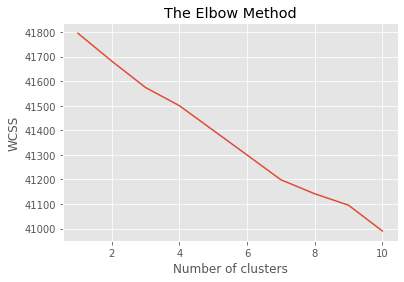

In [55]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(vec_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Judging by this graph, 7 seems to be a reasonable amount. Below we will apply the K-Means model for visualization, and easier comparison to a different algorithm. Since the data is high-dimensioned, some dimensionality reduction is required. For this we opted for principal component analysis, using a relevant module from sklearn. 

In [56]:
n_clusters = 7

In [ ]:
# Get feature names (title words)
feature_names = np.array(vect.get_feature_names_out())

kmeans_model = KMeans(n_clusters=n_clusters)
# Apply PCA transformation on the vectorized matrix
pca = PCA(n_components=2)
Y_sklearn = pca.fit_transform(vec_matrix.todense())

km_fitted = kmeans_model.fit(Y_sklearn)
km_prediction = kmeans_model.predict(Y_sklearn)

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# Plot the transformed data and color code by cluster prediction
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],
            c=km_prediction, s=40, cmap='viridis', linewidths=1, edgecolors='black')

# Plot the cluster centers for visual guidance
centers = km_fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, edgecolors='black')
ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()


### Ward linkage
A different algorithm, ward linkage, is a type of agglomerative clustering that recursively merges pairs of clusters, until the given distance or cluster amount is met. It's possible it produces better results with our data. For comparative reasons, the same cluster amount is used.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


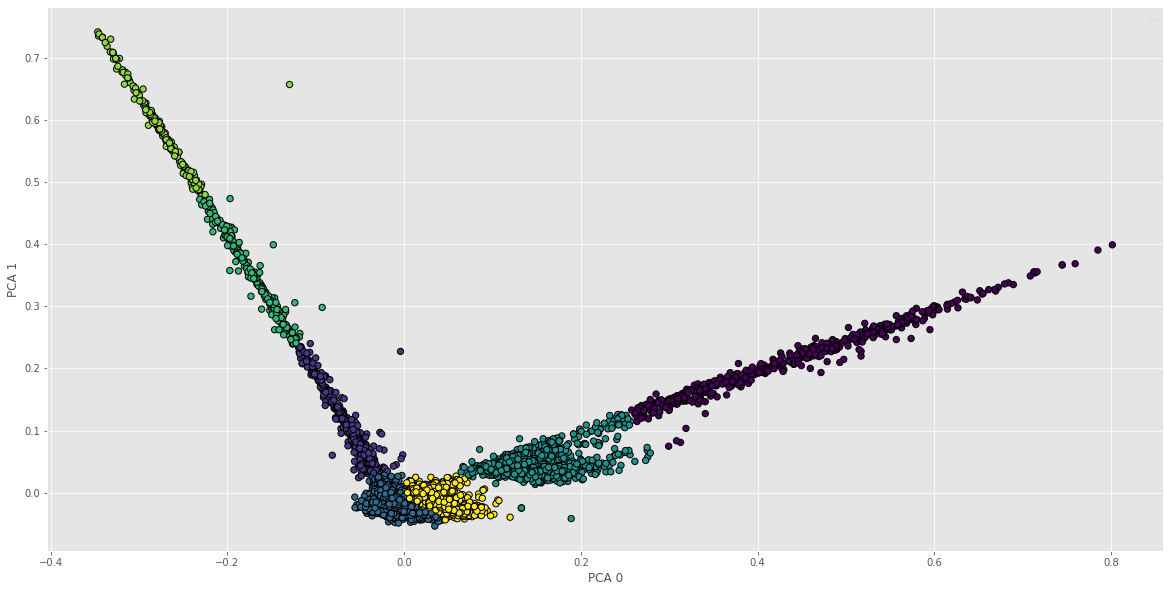

In [59]:
ward_model = AgglomerativeClustering(n_clusters=n_clusters)

ward_predicted = ward_model.fit_predict(Y_sklearn)

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# Plot the transformed data and color code by cluster prediction
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],
            c=ward_predicted, s=40, cmap='viridis', linewidths=1, edgecolors='black')

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()


### Evaluation
Visually, both models produce convincing and highly similar results. While visualizing using PCA is one way of evaluation, it's unfortunately not very accurate because of the information loss from dimensionality reduction. Let's add a few different evaluation metrics.

In [60]:
kmeans_labels = kmeans_model.labels_
ward_labels = ward_model.labels_
X = vec_matrix.toarray()

kmeans_silhouette = metrics.silhouette_score(vec_matrix, kmeans_labels, metric='euclidean')
ward_silhouette = metrics.silhouette_score(vec_matrix, ward_labels, metric='euclidean')

print("----Silhuette Coefficient: higher is better----")
print("K-Means: " + str(kmeans_silhouette))
print("Ward: " + str(ward_silhouette))

kmeans_calinski = metrics.calinski_harabasz_score(X, kmeans_labels)
ward_calinski = metrics.calinski_harabasz_score(X, ward_labels)

print("\n----Calinski-Harabasz Index : higher is better----")
print("K-Means: " + str(kmeans_calinski))
print("Ward: " + str(ward_calinski))

kmeans_davies_bouldin = metrics.davies_bouldin_score(X, kmeans_labels)
ward_davies_bouldin = metrics.davies_bouldin_score(X, ward_labels)

print("\n----Davies-Bouldin Index : lower is better----")
print("K-Means: " + str(kmeans_davies_bouldin))
print("Ward: " + str(ward_davies_bouldin))


----Silhuette Coefficient: higher is better----
K-Means: 0.0015095345680862127
Ward: 0.001661044038806789

----Calinski-Harabasz Index : higher is better----
K-Means: 68.00869300673052
Ward: 67.59243434470149

----Davies-Bouldin Index : lower is better----
K-Means: 8.958622380901856
Ward: 9.246317114644922


The two models are similar to a very high degree based on the scores, as is evident visually as well.

### Top features per cluster
This gives a good indicaton on if the model works reasonably or not. Below are the top 25 features of each identified cluster printed using the K-Means model. 

In [61]:
kmeans_model = KMeans(n_clusters=n_clusters)
fitted = kmeans_model.fit(vec_matrix)

# Extracts the top 25 features of each cluster and prints accordingly
common_words = kmeans_model.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' +
          ', '.join(feature_names[word_coord] for word_coord in centroid))


0 : say, apple, video, report, price, stock, microsoft, star, day, watch, amazon, deal, china, time, rate, market, update, study, ha, make, twitter, billion, sale, 'the, ebola
1 : google, year, facebook, review, million, recall, gm, game, miley, glass, cyrus, miley cyrus, throne, game throne, google glass, thrones', 'game, 'game thrones', car, android, season, movie review, gm recall, movie, user
2 : new, new york, york, album, trailer, video, release, new album, new study, feature, release new, study, movie, apple, facebook, star, launch, watch, app, ceo, season, new home, sale, home, twitter
3 : office, box office, box, ipad, office ipad, microsoft, microsoft office, weekend box, weekend, transformer, 'captain, million, u box, america, captain, age, jump, 'neighbors', street', 'transformers, captain america, 'captain america', apps, dominates, jump street'
4 : u, s, galaxy, samsung, samsung galaxy, galaxy s, u s, stock, u stock, p, sale, s p, rise, data, note, galaxy note, tab, rate,

It is by these results apparent that the model works well within the closest values, and closely mimics how a human would've sorted the keywords. 

---
## Classification


### k-NN model

The k-nearest neighbor algorithm (k-NN) is a supervised machine learning algorithm mainly used for classification. It functions by comparing the euclidean distance of the new datapoint to its nearest neighbors in the training dataset, then assigning it the answer of its closest neighbors.

#### Find the most accurate k-value

In order to run, k-NN needs to know how many of its closest neighbors it should look at in order to make a decision. This is called the *k-value*, and how large it is can vastly effect the accuracy of the algorithm. The easiest way to find it is to simply test a few k-values and see which one gets the best results on the dataset you are using. This means we need to run the model several times in order to find the most accurate value of k, and in order to avoid bias leaking into this decision from using the training set, we further split it into a training set and a validation set. The validation set can then also be used for fitting with our feature selector.

In [35]:
# Split the training data into a training and validation set for the supervised learning
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

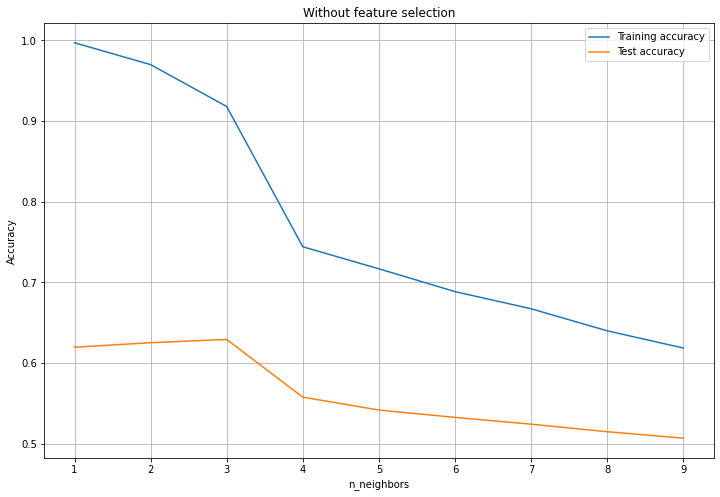

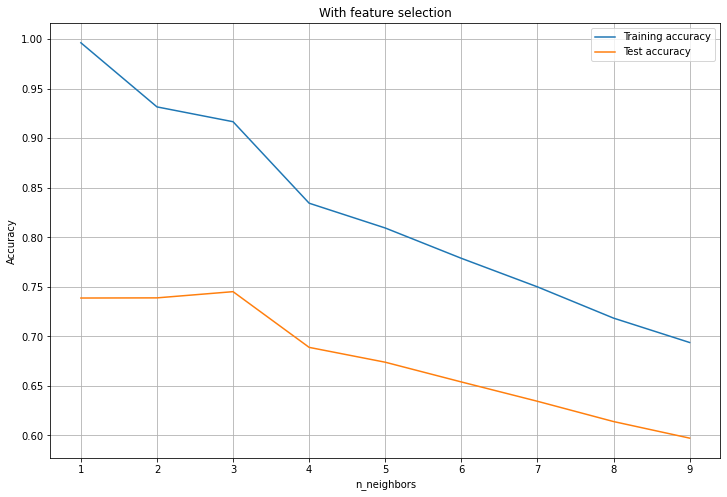

In [36]:
# Implements feature selection using SelectFromModel, together with a Linear Support Vector classifier
select = SelectFromModel(
    LinearSVC(C=1, penalty='l1', dual=False, class_weight='balanced'), threshold="median")
select.fit(X_valid, y_valid)
X_valid_l1 = select.transform(X_valid)
X_train_l1 = select.transform(X_train)
X_test_l1 = select.transform(X_test)

def find_K_value(training_data_X, training_data_y, test_data, title):
  # Find the most accurate k-value 
  training_accuracy = []
  test_accuracy = []
  k_arr = range(1, 10)

  # Creates and trains all of the classifiers, and saves the results in arrays
  for k in k_arr:
    clf = KNeighborsClassifier(n_neighbors=k)  # Initializes kNN classifier with k neighbors
    clf.fit(training_data_X, training_data_y) # Fits the classifier to the data
    training_accuracy.append(clf.score(training_data_X, training_data_y)) # Records training set accuracy
    test_accuracy.append(clf.score(test_data, y_test))  # Records generalization accuracy

  plt.figure(figsize=(12, 8))
  plt.plot(k_arr, training_accuracy, label="Training accuracy")
  plt.plot(k_arr, test_accuracy, label="Test accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("n_neighbors")
  plt.legend()
  plt.grid()
  plt.title(title)
  plt.show()


find_K_value(X_valid, y_valid, X_test, "Without feature selection")
find_K_value(X_valid_l1, y_valid, X_test_l1, "With feature selection")

We can see that the most accurate k-value in this run is 3 *without* feature selection and *with* feature selection.
#### Apply most accurate model

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


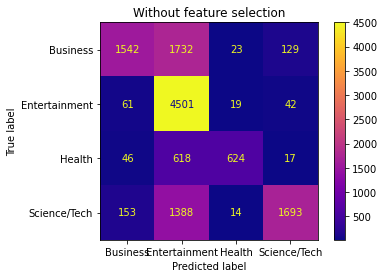

Accuracy: 0.6634


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


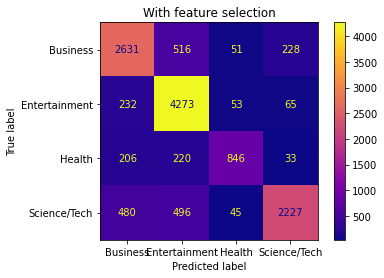

Accuracy: 0.7917


In [38]:
# KNN-method without feature selection
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap="plasma")
plt.title("Without feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test, y_test), 4)))


#KNN-method with feature selection
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train_l1, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test_l1)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test_l1, y_test, cmap="plasma")  
plt.title("With feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test_l1, y_test), 4)))

### Complement Naive Bayes

Complement Naive Bayes is a classifier designed to correct some of the assumptions made by the Multinomial Naive Bayes classifier. Multionomial Naive Bayes is a common method for classification in supervised learning with categorical text data, however it doesn't work very well on imbalanced datasets, which our dataset happens to be. Complement Naive Bayes takes this into account though, which is the main reason we chose to try and use it here.

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


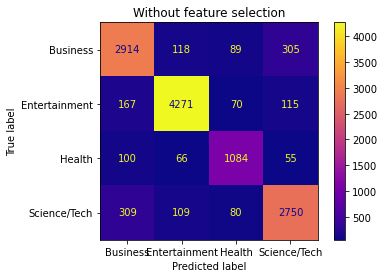

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.8744


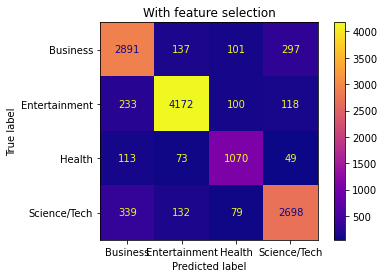

Accuracy: 0.8595


In [39]:
# Naive bayes method without feature selection
cnb = ComplementNB()

cnb.fit(X_train, y_train)

predictions = cnb.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(cnb, X_test, y_test, cmap="plasma")  
plt.title("Without feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(cnb.score(X_test, y_test), 4)))


# Naive bayes method with feature selection
cnb_fs = ComplementNB()

cnb_fs.fit(X_train_l1, y_train)

predictions = cnb_fs.predict(X_test_l1)

# Plot confusion matrix
plot_confusion_matrix(cnb_fs, X_test_l1, y_test, cmap="plasma")  
plt.title("With feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(cnb_fs.score(X_test_l1, y_test), 4)))

### Support-vector machine

Support-vector machine (or SVM) is another algorithm also used for classification. It works by finding the areas dominated by different groups of datapoints, then finding in which area new datapoints should fit.

C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


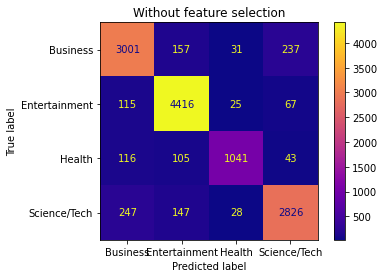

Accuracy: 0.8954


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


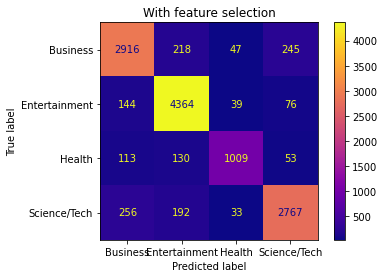

Accuracy: 0.8773


In [40]:
# SVM method without feature selection
clf = svm.SVC(decision_function_shape='ovo') # ovo = "one vs one", aka compare all possible answers to all other possible answers 
clf.fit(X_train, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test, y_test, cmap="plasma")  
plt.title("Without feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test, y_test), 4)))


# SVM mehod with feature selection
clf.fit(X_train_l1, y_train) # Fits the classifier to the data

predictions = clf.predict(X_test_l1)

# Plot confusion matrix
plot_confusion_matrix(clf, X_test_l1, y_test, cmap="plasma")  
plt.title("With feature selection")
plt.show()

# Print accuracy
print("Accuracy: " + str(round(clf.score(X_test_l1, y_test), 4)))

---
## Discussion

### Reflect on your results, and how one might continue to improve them.

Our massive database meant that actually running the code could take very long, up to several hours if we were unlucky. To make this easier whilst working and iterating the code we used a smaller database size so we did not need to waste so much time on waiting between code executions.

## Acknowledgments

### For each group member, describe what they did.

(Write into continous text later)

Markus - 

Martin - Clustering, had the fastest computer for running everything

Saga - Classification, creating lit memes

Vilhelm - 

## Final meme

Include here a meme describing your experience in this module.

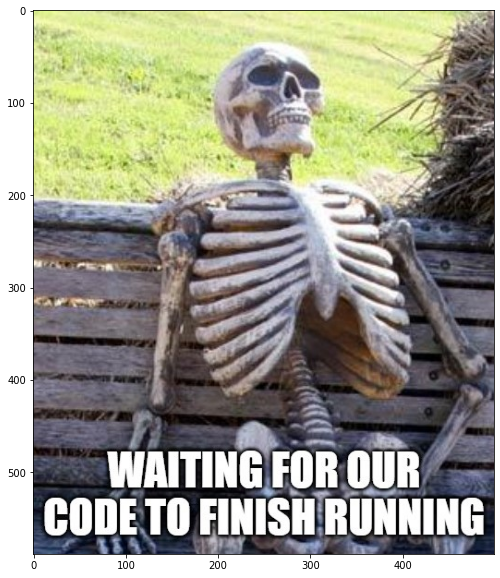

In [11]:
import imageio
meme = imageio.imread('meme.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(meme)